In [4]:
import pandas as pd
import numpy as np
import pathlib  

In [5]:
IN_PARQUET = pathlib.Path("streamlit_app/data_sample/articles_41_classification_sample.parquet")

In [41]:
df= pd.read_parquet(IN_PARQUET)
df

,title,linked_article_titles,sections_count,categories,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,uppercase_word_count,...,pca_190,pca_191,pca_192,pca_193,pca_194,pca_195,pca_196,pca_197,pca_198,pca_199
0,calvin baker,"[americans, writer, chicago, amherst college, ...",4,"[Writers from Chicago, Year of birth unknown, ...",821.0,68.0,15.0,11.014706,4.533333,0.0,...,0.020293,-0.029891,-0.024115,0.003076,0.000825,-0.011407,0.027296,-0.001796,-0.029850,-0.004293
1,cyma zarghami,"[iran, usa, cable television, president, nicke...",4,"[1960s births, Living people, Nickelodeon]",797.0,64.0,10.0,11.390625,6.400000,2.0,...,-0.023147,0.017652,-0.024739,0.005392,0.007928,-0.009061,-0.010217,0.003107,0.031302,0.040179
2,crewe alexandra f.c.,"[efl league one, england, association football...",12,"[1877 establishments in England, Crewe, Englis...",10487.0,1195.0,71.0,7.722176,16.830986,17.0,...,-0.000259,0.048913,0.030453,0.027587,-0.026625,0.035104,0.017302,-0.025808,0.030496,-0.015809
3,ludiano,"[blenio (district), acquarossa, malvaglia, sem...",4,[Former municipalities of Ticino],1578.0,183.0,11.0,7.251366,16.636364,2.0,...,0.025063,-0.009168,-0.051436,0.005410,0.021555,0.008923,-0.075740,-0.017535,-0.056141,-0.013039
4,gonneville-en-auge,"[communes of france, normandy, regions of fran...",2,[Communes in Calvados],1352.0,177.0,7.0,5.841808,25.285714,1.0,...,-0.008725,-0.046451,-0.015386,-0.010859,0.017623,-0.041452,0.042489,-0.024375,0.007214,-0.017589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,state fair (1945 movie),"[dana andrews, 20th century fox]",2,"[1945 musical movies, 1940s American musical m...",786.0,105.0,4.0,6.476190,26.250000,0.0,...,-0.021446,0.015834,-0.031628,-0.022376,0.050536,-0.050250,0.007365,0.013087,-0.049103,0.045034
9996,francesco mussoni,"[list of captains regent of san marino, giacom...",2,"[1971 births, Captains Regent of San Marino, L...",2015.0,209.0,9.0,7.669856,23.222222,0.0,...,-0.011270,-0.000976,0.000285,0.008664,-0.053851,0.034931,-0.017927,-0.014563,-0.034074,0.059675
9997,tristan und isolde,"[opera, richard wagner, legend, germany, poet,...",14,"[1860s operas, Operas by Richard Wagner]",7948.0,1312.0,90.0,5.033537,14.577778,6.0,...,0.003438,0.016885,0.014328,-0.021615,-0.002915,0.000197,0.046381,-0.012012,-0.017719,0.048650
9998,just like you (three days grace song),"[three days grace, three days grace (album), a...",4,"[2004 songs, Three Days Grace songs, Hard rock...",3445.0,375.0,34.0,8.064000,11.029412,2.0,...,0.046608,0.052622,-0.022392,0.058755,-0.064713,-0.007940,0.070335,-0.023800,0.089322,0.021139


In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the features for clustering

# Exclude the columns you don't want
features = df.drop(columns=['title', 'linked_article_titles', 'categories'])

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Evaluating k: 100%|██████████| 33/33 [01:05<00:00,  2.00s/it]


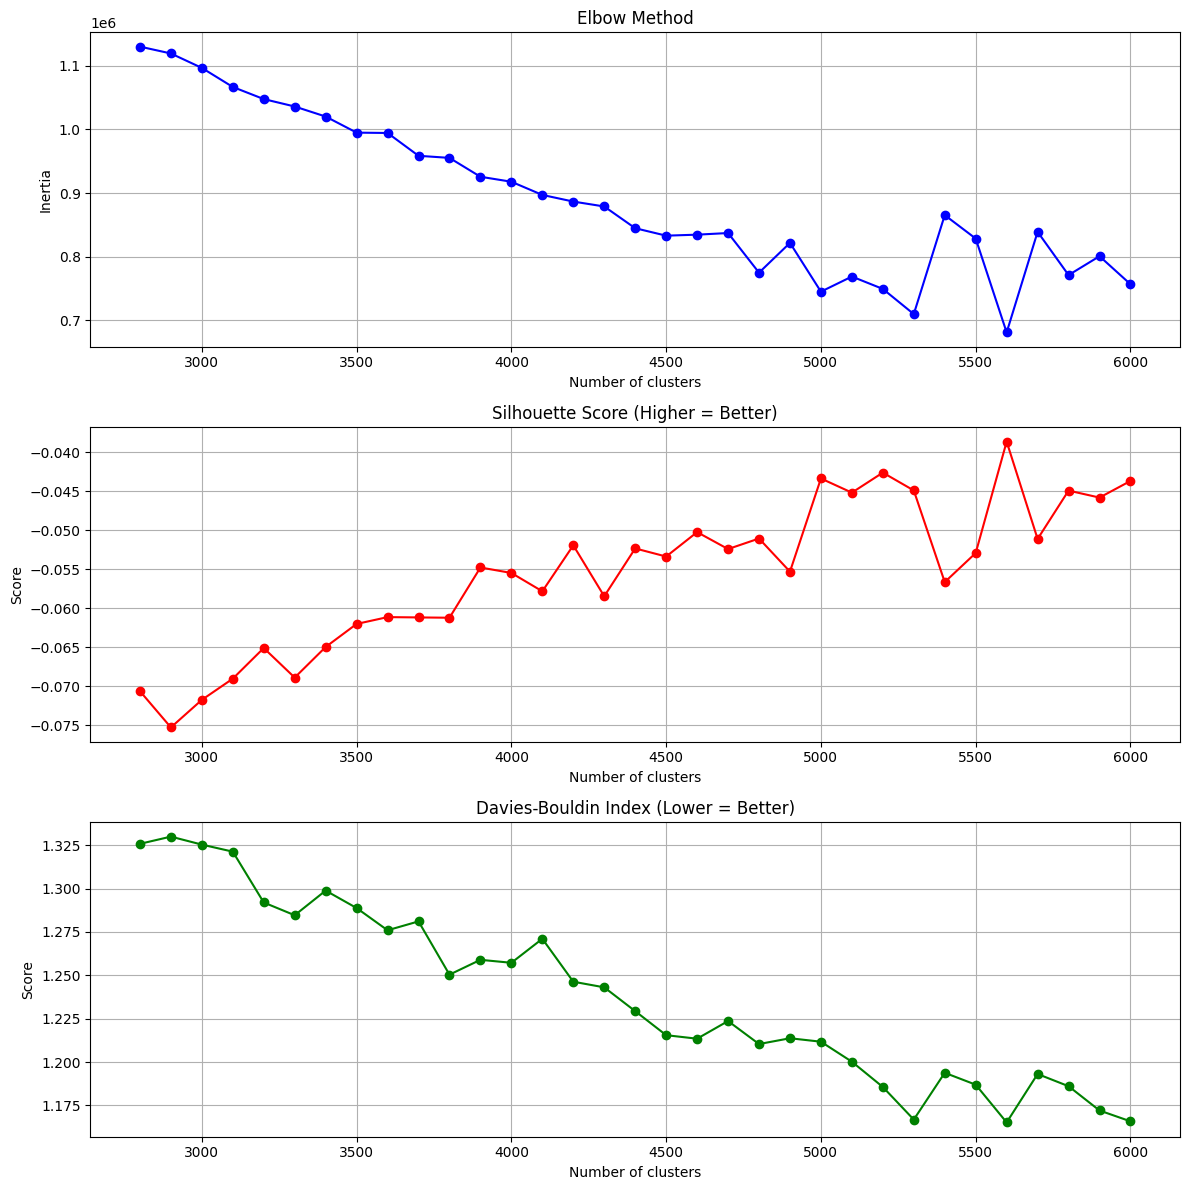


Optimal k-values:
- Best Silhouette: k=5600
- Best Davies-Bouldin: k=5600


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from joblib import Parallel, delayed
from tqdm import tqdm  # Progress bar
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Feature selection and scaling
features = df.drop(columns=['title', 'linked_article_titles', 'categories'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

def evaluate_k(k, data):
    model = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        batch_size=1000,
        max_iter=100,          # Faster convergence
        tol=1e-4,             # Early stopping
        n_init=3              # Reduce repeated runs
    )
    labels = model.fit_predict(data)
    unique_clusters = len(np.unique(labels))
    
    # Skip metrics if clusters are degenerate
    metrics = {
        'k': k,
        'inertia': model.inertia_,
        'silhouette': np.nan,
        'davies_bouldin': np.nan,
        'n_clusters': unique_clusters
    }
    
    if unique_clusters > 1:  # Metrics require at least 2 clusters
        try:
            metrics['silhouette'] = silhouette_score(data, labels)
        except:
            pass
        try:
            metrics['davies_bouldin'] = davies_bouldin_score(data, labels)
        except:
            pass
    
    return metrics

# Evaluate k in parallel with progress bar
k_values = range(2800, 6001, 100)

# Wrap Parallel execution with tqdm for progress tracking
results = Parallel(n_jobs=-1)(
    delayed(evaluate_k)(k, scaled_features) for k in tqdm(k_values, desc="Evaluating k")
)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Inertia
ax1.plot(results_df['k'], results_df['inertia'], marker='o', color='b')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# Silhouette
ax2.plot(results_df['k'], results_df['silhouette'], marker='o', color='r')
ax2.set_title('Silhouette Score (Higher = Better)')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Score')
ax2.grid(True)

# Davies-Bouldin
ax3.plot(results_df['k'], results_df['davies_bouldin'], marker='o', color='g')
ax3.set_title('Davies-Bouldin Index (Lower = Better)')
ax3.set_xlabel('Number of clusters')
ax3.set_ylabel('Score')
ax3.grid(True)

plt.tight_layout()
plt.show()

# Print best k-values
print("\nOptimal k-values:")
print(f"- Best Silhouette: k={results_df.loc[results_df['silhouette'].idxmax(), 'k']}")
print(f"- Best Davies-Bouldin: k={results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']}")

In [13]:
df['categories']

0                                                  [Months]
1                                                  [Months]
2         [Art, Non-verbal communication, Basic English ...
3                  [Basic English 850 words, Vowel letters]
4                     [Basic English 850 words, Atmosphere]
                                ...                        
375853                                                   []
375854    [Theodore Roosevelt, Buildings and structures ...
375855          [Warren G. Harding, Presidential libraries]
375856                                                   []
375857                                                   []
Name: categories, Length: 375858, dtype: object

In [15]:
# Flatten all category arrays and get unique values
distinct_categories = set(cat for sublist in df['categories'] for cat in sublist)
print(len(distinct_categories))

16419


In [54]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your data (assuming it's in a DataFrame `df`)
features = df.drop(columns=['title', 'linked_article_titles', 'categories'])

# Standardize features (crucial for DBSCAN)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Run DBSCAN
dbscan = DBSCAN(eps=10, min_samples=5)  # Adjust hyperparameters
clusters = dbscan.fit_predict(scaled_features)

# Add cluster labels to the original DataFrame
df['cluster'] = clusters

# Analyze results
print("Cluster distribution:")
print(pd.Series(clusters).value_counts())

Cluster distribution:
-1     7716
 0      562
 8      162
 19     161
 13     110
       ... 
 48       5
 57       5
 49       5
 67       4
 71       4
Name: count, Length: 108, dtype: int64


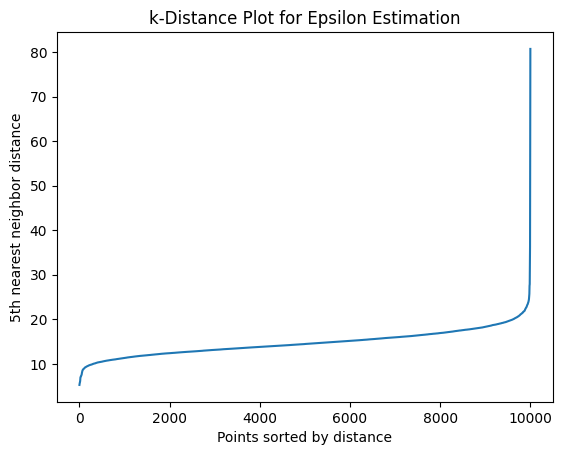

In [48]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

nn = NearestNeighbors(n_neighbors=20)  # k = min_samples
nn.fit(scaled_features)
distances, _ = nn.kneighbors(scaled_features)
distances = np.sort(distances[:, -1])  # Sort the k-th neighbor distances

plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th nearest neighbor distance')
plt.title('k-Distance Plot for Epsilon Estimation')
plt.show()